# ADS 509 Text Mining Project

**Lorena Dorado & Parisa Kamizi** 

## Load and Explore the Dataset Structure

In [77]:
# Import Libraries
import pandas as pd
import numpy as np
import glob
import os
import html
import re
import string
import json
import logging
from datetime import datetime
from collections import Counter
from collections import defaultdict
from tqdm import tqdm
from langdetect import DetectorFactory
from typing import List, Dict, Any
import random

# Text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect
import spacy
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Topic Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download required NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

We set up logging to track progress and errors, then load and combine DeepSeek CSV files into a dataframe. Dates are converted to datetime format, and text processing is configured with stopwords and lemmatization. Errors in file loading are logged, but processing continues with available data. Finally, we log the total rows loaded and display dataset information.













In [4]:
# Configure Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('text_mining.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)
logger.info("Setup complete")

2025-02-22 18:50:59,474 - INFO - Setup complete


In [5]:
# Set up text processing configurations
stop_words = set(stopwords.words('english') + 
                 stopwords.words('spanish') + 
                 stopwords.words('french') + 
                 stopwords.words('german'))

# Add custom stopwords
custom_stopwords = {'ul', 'li', 'ol', 'div', 'span', 'href', 'src', 'img', 'p', 'br', 'nbsp', 'char', 'id', 'av', 'lv'}
stop_words.update(custom_stopwords)

website_stopwords = ['transparency', 'accept', 'partner', 'click', 'consent', 'cookie', 'policy', 'privacy', 'terms', 'use', 'agreement', 'site']
stop_words.update(website_stopwords)

punctuation_set = set(string.punctuation) - {"#"}  # Keep hashtags
lemmatizer = WordNetLemmatizer()

#### Load Data

In [7]:
# Load the data
column_mapping = {
    'source_name': 'source',
    'publishedAt': 'date',
    'content': 'text',
    'title': 'title',
    'description': 'description'
}

csv_files = glob.glob(os.path.join('.', '*.csv'))
dfs = []

for file in csv_files:
    try:
        temp_df = pd.read_csv(file)
        dfs.append(temp_df)
        logger.info(f"Successfully loaded {file}")
    except Exception as e:
        logger.error(f"Error reading file {file}: {str(e)}")

if not dfs:
    raise ValueError("No CSV files were successfully loaded")

news_df = pd.concat(dfs, ignore_index=True)
news_df = news_df[column_mapping.keys()].rename(columns=column_mapping)
news_df['date'] = pd.to_datetime(news_df['date'])

print("\nInitial Dataset Info:")
print(news_df.info())
print("\nFirst few rows:")
print(news_df.head())

2025-02-22 18:50:59,542 - INFO - Successfully loaded ./Deepseek_Day_Four.csv
2025-02-22 18:50:59,548 - INFO - Successfully loaded ./Deepseek_Day_One.csv
2025-02-22 18:50:59,552 - INFO - Successfully loaded ./deepseek_20250214.csv
2025-02-22 18:50:59,557 - INFO - Successfully loaded ./Deepseek_Day_Three.csv
2025-02-22 18:50:59,562 - INFO - Successfully loaded ./deepseek_20250222.csv
2025-02-22 18:50:59,567 - INFO - Successfully loaded ./deepseek_20250220.csv
2025-02-22 18:50:59,571 - INFO - Successfully loaded ./Deepseek_Day_Five.csv
2025-02-22 18:50:59,576 - INFO - Successfully loaded ./Deepseek_Day_Two.csv



Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       856 non-null    object             
 1   date         856 non-null    datetime64[ns, UTC]
 2   text         856 non-null    object             
 3   title        856 non-null    object             
 4   description  828 non-null    object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 40.8+ KB
None

First few rows:
             source                      date  \
0  Business Insider 2025-02-03 12:23:17+00:00   
1          Hackaday 2025-02-04 00:00:00+00:00   
2       Gizmodo.com 2025-02-03 20:45:34+00:00   
3        Xataka.com 2025-02-03 13:30:24+00:00   
4    The New Yorker 2025-02-03 11:00:00+00:00   

                                                text  \
0  Jakub Porzycki/NurPhoto via Getty Images\r\n<u...   

## Data Cleaning with Tokenization and Normalization

The text processing pipeline applies a series of cleaning steps, including removing special characters, normalizing whitespace, and lemmatizing tokens while filtering out stopwords and numbers. Duplicate articles are identified and removed based on content similarity. Language detection is performed, and a cleaned version of the text is created for further analysis. Finally, tokens are generated for processed text, and a sample of the cleaned data is displayed.









In [9]:
#### Text processing pipeline functions
def validate_text(text):
    """Check if text is valid"""
    return "" if not isinstance(text, str) or pd.isna(text) else text

def basic_clean(text):
    """Basic text cleaning"""
    return (html.unescape(text)
            .lower()
            .replace('\n', ' ')
            .replace('\r', ' '))

def remove_special_chars(text):
    """Remove special characters and patterns"""
    return re.sub(r'\[\+\d+ chars\]|https?://\S+|â€™|â€"|[^\w\s\-\'.,!?]', ' ', text)

def remove_num_patterns(text):
    """Remove date patterns and numbers (including those with commas)"""
    return re.sub(r'\b\d{1,4}[-/]\d{1,2}[-/]\d{1,4}\b|\b\d{1,3}(,\d{3})*(\.\d+)?\b|\b\d+\b', '', text)

def clean_whitespace(text):
    """Clean extra whitespace"""
    return re.sub(r'\s+', ' ', text).strip()

def remove_punct(text):
    """Remove punctuation"""
    return "".join(ch for ch in text if ch not in punctuation_set)

def get_tokens(text):
    """Get tokens without stopwords, lemmatize, remove numbers, and filter short tokens"""
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc 
            if token.is_alpha 
            and len(token.text) > 2 
            and not token.is_stop 
            and token.lemma_.lower() not in stop_words 
            and not token.like_num]

def detect_lang(text):
    """Detect language safely"""
    try:
        return 'unknown' if len(text.strip()) < 50 else detect(text)
    except:
        return 'unknown'

def remove_duplicates(df):
    """Remove duplicate articles based on content similarity"""
    df['text_signature'] = df['title'] + df['text'].str[:200]
    original_len = len(df)
    df = df.drop_duplicates(subset=['text_signature'])
    df = df.drop('text_signature', axis=1)
    logger.info(f"Removed {original_len - len(df)} duplicate articles")
    return df

In [10]:
def process_text(text, steps=None):
    if steps is None:
        steps = ['validate', 'basic', 'special', 'num_patterns', 'whitespace', 'punct', 'tokens']
    
    text = validate_text(text)
    
    pipeline_steps = {
        'validate': validate_text,
        'basic': basic_clean,
        'special': remove_special_chars,
        'num_patterns': remove_num_patterns,
        'whitespace': clean_whitespace,
        'punct': remove_punct,
        'tokens': get_tokens
    }
    
    for step in steps:
        text = pipeline_steps[step](text)
    
    return text if isinstance(text, list) else text  # Return tokens as a list if the last step was tokenization

In [11]:
# Remove duplicates
logger.info("Removing duplicates...")
news_df = remove_duplicates(news_df)

# Process text
logger.info("Processing text...")
tqdm.pandas()
news_df['clean_text'] = news_df['text'].progress_apply(
    lambda x: process_text(x, ['validate', 'basic', 'special', 'num_patterns', 'whitespace']))

# Detect languages
logger.info("Detecting languages...")
news_df['language'] = news_df['clean_text'].progress_apply(detect_lang)

# Create cleaned content
logger.info("Creating cleaned content...")
news_df['cleaned_content'] = news_df['text'].progress_apply(
    lambda x: process_text(x, ['validate', 'basic', 'punct', 'whitespace']))

# Generate tokens
logger.info("Generating tokens...")
def get_cleaned_text_and_tokens(text):
    cleaned = process_text(text, ['validate', 'basic', 'punct', 'whitespace'])
    tokens = get_tokens(cleaned)
    return ' '.join(tokens), tokens

temp_results = news_df['text'].progress_apply(get_cleaned_text_and_tokens)
news_df['Cleaned_Text'] = temp_results.apply(lambda x: x[0])
news_df['Tokens'] = temp_results.apply(lambda x: x[1])

# Display processed data sample
print("\nProcessed DataFrame columns:")
print(news_df.columns.tolist())
print("\nSample of processed data:")
print(news_df[['source', 'date', 'clean_text', 'language', 'Tokens']].head())

2025-02-22 18:50:59,648 - INFO - Removing duplicates...
2025-02-22 18:50:59,654 - INFO - Removed 362 duplicate articles
2025-02-22 18:50:59,655 - INFO - Processing text...
100%|██████████████████████████████████████| 679/679 [00:00<00:00, 21375.74it/s]
2025-02-22 18:50:59,728 - INFO - Detecting languages...
100%|████████████████████████████████████████| 679/679 [00:04<00:00, 142.59it/s]
2025-02-22 18:51:04,494 - INFO - Creating cleaned content...
100%|██████████████████████████████████████| 679/679 [00:00<00:00, 22882.86it/s]
2025-02-22 18:51:04,526 - INFO - Generating tokens...
100%|████████████████████████████████████████| 679/679 [00:06<00:00, 101.28it/s]


Processed DataFrame columns:
['source', 'date', 'text', 'title', 'description', 'clean_text', 'language', 'cleaned_content', 'Cleaned_Text', 'Tokens']

Sample of processed data:
             source                      date  \
0  Business Insider 2025-02-03 12:23:17+00:00   
1          Hackaday 2025-02-04 00:00:00+00:00   
2       Gizmodo.com 2025-02-03 20:45:34+00:00   
3        Xataka.com 2025-02-03 13:30:24+00:00   
4    The New Yorker 2025-02-03 11:00:00+00:00   

                                          clean_text language  \
0  jakub porzycki nurphoto via getty images ul li...       en   
1  the deepseek large language models llm have be...       en   
2  in what could be softbank s newest trick to ma...       en   
3  el hardware utilizado por deepseek para entren...       es   
4  last week, shortly before the start of the chi...       en   

                                              Tokens  
0  [jakub, porzyckinurphoto, getty, image, ullith...  
1  [deepseek, large, lang

## Descriptive Statistics

The descriptive analysis of the news dataset reveals key insights into its linguistic structure. The dataset contains 679 documents with a total of 10,904 tokens, of which 4,327 are unique, resulting in a lexical diversity of 0.397. The total character count across all tokens is 72,706. The most frequent words include deepseek (502 occurrences), openai (149), model (121), chinese (110), and artificial (81), suggesting a strong emphasis on AI and technology-related topics. 


In [13]:
def descriptive_stats_all(df: pd.DataFrame, tokens_col: str = 'Tokens', 
                         text_col: str = 'text', title: str = "Dataset",
                         num_tokens: int = 5, plot: bool = True) -> Dict[str, Any]:

    # Initialize results dictionary
    stats = {}
    
    # Get all tokens
    all_tokens = [token for tokens in df[tokens_col] for token in tokens]
    token_counts = Counter(all_tokens)
    
    # Basic token statistics
    stats['total_tokens'] = len(all_tokens)
    stats['unique_tokens'] = len(set(all_tokens))
    stats['total_characters'] = len(''.join(all_tokens))
    stats['lexical_diversity'] = stats['unique_tokens'] / stats['total_tokens'] if stats['total_tokens'] > 0 else 0
    
    # Document statistics
    stats['total_documents'] = len(df)
    
    # Token length statistics
    token_lengths = [len(token) for token in all_tokens]

    # Top tokens
    stats['top_tokens'] = token_counts.most_common(num_tokens)
    
    # Print results if verbose
    print(f"\nDescriptive Statistics for '{title}':")
    print("-" * 50)
    print(f"Total documents: {stats['total_documents']:,}")
    
    print(f"\nToken-level Statistics:")
    print(f"Total tokens: {stats['total_tokens']:,}")
    print(f"Unique tokens: {stats['unique_tokens']:,}")
    print(f"Total characters: {stats['total_characters']:,}")
    print(f"Lexical diversity: {stats['lexical_diversity']:.3f}")
    
    print(f"\nTop {num_tokens} most frequent tokens:")
    for token, count in stats['top_tokens']:
        print(f"{token}: {count:,}")
    
    return stats

stats = descriptive_stats_all(news_df, tokens_col='Tokens', text_col='text',
                              title="News Articles", num_tokens=10, plot=True)


Descriptive Statistics for 'News Articles':
--------------------------------------------------
Total documents: 679

Token-level Statistics:
Total tokens: 10,904
Unique tokens: 4,327
Total characters: 72,706
Lexical diversity: 0.397

Top 10 most frequent tokens:
deepseek: 502
openai: 149
model: 121
chinese: 110
artificial: 81
chatgpt: 76
nvidia: 67
tech: 66
new: 64
app: 62


## Wordclouds

The word cloud visualization provides a high-level overview of the most prominent words in the dataset. By aggregating text data from 679 news articles, the word cloud highlights frequently occurring terms, with larger words representing higher frequency. The visualization confirms the dominance of AI and technology-related topics, as observed in the token frequency analysis, with terms like *deepseek




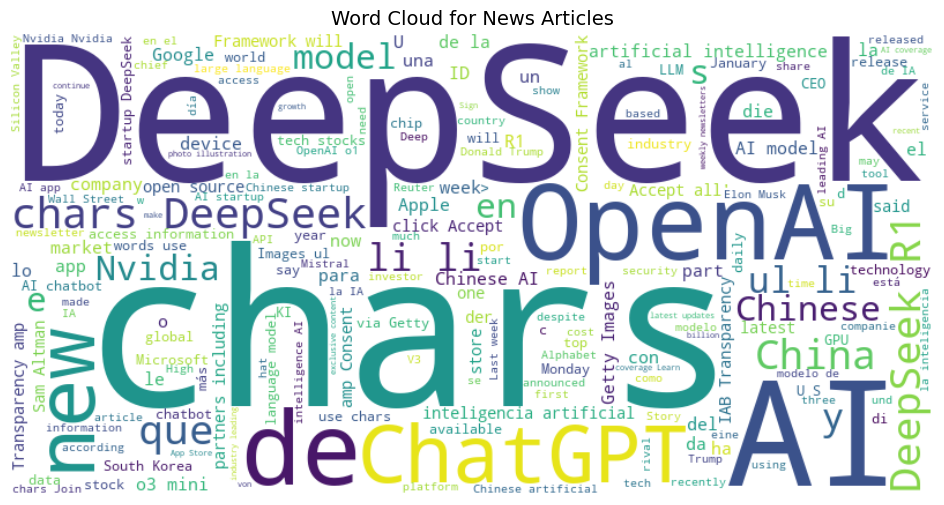

In [22]:
def generate_wordcloud(df: pd.DataFrame, text_col: str = 'text', title: str = "Dataset"):
    """Generate and display a word cloud for the given text column."""
    
    # Convert all text to strings and handle missing values
    all_text = ' '.join(df[text_col].dropna().astype(str))  
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='viridis', max_words=200).generate(all_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {title}", fontsize=14)
    plt.show()

generate_wordcloud(news_df, text_col='text', title="News Articles")


## Topic Modeling

TF-IDF and Count vectorization were applied to extract key features from the cleaned text, reducing noise and emphasizing important terms. The TF-IDF vectorizer adjusts for word importance across documents, while the Count vectorizer captures raw frequency. By limiting features to the top 5,000 words and applying filtering thresholds, the models focus on relevant terms. The topic display function ranks words within each topic by significance, aiding in thematic analysis. This approach helps in identifying dominant topics in the dataset, reinforcing previous findings about AI and technology trends.









In [24]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words), max_features=5000, max_df=0.95, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(news_df['clean_text'])

# Create Count vectorizer
count_vectorizer = CountVectorizer(stop_words=list(stop_words), max_features=5000, max_df=0.95, min_df=2)
count_matrix = count_vectorizer.fit_transform(news_df['clean_text'])

In [26]:
# Function to display topics
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## NMF

The NMF model was applied to extract five distinct topics from the dataset, revealing key themes in AI and technology discussions. 

Topic 00 highlights terms related to digital frameworks, partnerships, and devices, suggesting a focus on industry collaborations and infrastructure. 

Topic 01 is dominated by DeepSeek, ChatGPT, and Nvidia, indicating frequent mentions of AI company and products.

Topic 02 emphasizes Chinese technology, models, and apps, reflecting discussions on regional AI developments.

Topic 03 features OpenAI, ChatGPT, and Altman, pointing to research, leadership, and innovations in AI.

Lastly, Topic 04 revolves around weekly updates and newsletters, suggesting ongoing industry coverage and information sharing. 

In [29]:
# Fit NMF model
n_topics = 5
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_output = nmf_model.fit_transform(tfidf_matrix)

# Display the topics
feature_names = tfidf_vectorizer.get_feature_names_out()
print("NMF Topics:")
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out())

NMF Topics:

Topic 00
  iab (9.55)
  words (9.55)
  partners (9.55)
  device (9.29)
  framework (9.26)

Topic 01
  deepseek (20.24)
  r1 (6.16)
  chatgpt (2.73)
  nvidia (1.99)
  bloomberg (1.12)

Topic 02
  chinese (1.80)
  model (1.37)
  intelligence (1.14)
  tech (1.09)
  app (1.08)

Topic 03
  openai (9.51)
  chatgpt (3.40)
  o3 (3.16)
  altman (3.15)
  mini (3.11)

Topic 04
  weekly (5.24)
  coverage (4.91)
  learn (4.91)
  updates (4.91)
  newsletters (4.89)


/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


## LSA

The LSA model identified five key topics in the dataset, aligning closely with previously observed themes. 

Topic 00 emphasizes partners, devices, and partnerships, indicating discussions on industry collaborations and technological integration. 

Topic 01 is centered around DeepSeek, OpenAI, and ChatGPT, reinforcing the prominence of major AI company and products. 

Topic 02 also features DeepSeek and ChatGPT, but with additional mentions of flyer and GPU, suggesting technical aspects of AI deployment. 

Topic 03 is overwhelmingly dominated by OpenAI, Altman, and ChatGPT, highlighting a strong focus on OpenAI’s developments and leadership. 

Lastly, Topic 04 revolves around weekly updates, newsletters, and coverage, indicating a consistent flow of information related to AI and technology news. 








In [32]:
# Fit LSA model
lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_output = lsa_model.fit_transform(tfidf_matrix)

print("\nLSA Topics:")
display_topics(lsa_model, tfidf_vectorizer.get_feature_names_out())


LSA Topics:

Topic 00
  partners (5.05)
  words (5.05)
  iab (5.05)
  device (4.92)
  part (4.91)

Topic 01
  deepseek (7.32)
  r1 (2.44)
  openai (2.14)
  chatgpt (1.72)
  model (1.01)

Topic 02
  deepseek (2.26)
  r1 (0.84)
  chatgpt (0.58)
  flyer (0.25)
  gpu (0.21)

Topic 03
  openai (40.44)
  o3 (15.29)
  mini (15.04)
  altman (14.27)
  chatgpt (14.06)

Topic 04
  weekly (15.77)
  updates (14.88)
  learn (14.88)
  coverage (14.88)
  newsletters (14.82)


## LDA

The LDA model extracted five key topics, reinforcing the dataset's emphasis on AI and related developments. 

Topic 00 highlights DeepSeek, Chinese models, and Getty, suggesting discussions on AI advancements in China and media-related AI applications. 

Topic 01 focuses on DeepSeek, South Korea, and Daily, indicating regional AI developments and news coverage. 

Topic 02 prominently features DeepSeek, NVIDIA, and OpenAI, reflecting industry leaders and AI companies.

Topic 03, with terms like DeepSeek, store, and part, suggests discussions on AI applications, products, and distribution channels. 

Finally, Topic 04 is dominated by OpenAI, DeepSeek, and ChatGPT, reaffirming the strong presence of AI products.


In [35]:
# Fit LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_output = lda_model.fit_transform(count_matrix)

print("\nLDA Topics:")
display_topics(lda_model, count_vectorizer.get_feature_names_out())


LDA Topics:

Topic 00
  deepseek (3.57)
  chinese (2.13)
  model (1.72)
  new (1.20)
  getty (1.19)

Topic 01
  deepseek (2.52)
  south (1.93)
  chinese (1.50)
  korea (1.48)
  daily (1.34)

Topic 02
  deepseek (11.83)
  nvidia (3.12)
  r1 (2.98)
  openai (1.44)
  artificial (1.12)

Topic 03
  deepseek (4.78)
  store (1.39)
  chinese (1.32)
  including (1.27)
  part (1.27)

Topic 04
  openai (6.65)
  deepseek (3.72)
  chatgpt (2.73)
  mini (2.10)
  o3 (2.05)


In [37]:
# Visualize LDA results
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.lda_model.prepare(lda_model, count_matrix, count_vectorizer)
pyLDAvis.display(lda_vis)

The visualization above shows that Topic 1 is the largest, while Topics 5 and 3 overlap, and Topics 2 and 4 are more distinct. The most frequent word in Topic 2 is DeepSeek (11.83), making it the most dominant term across all topics. Topic 0 emphasizes DeepSeek (3.57) and Chinese (2.13), while Topic 1 highlights DeepSeek (2.52) alongside South (1.93) and Korea (1.48). Topic 3, with DeepSeek (4.78), focuses on AI product distribution, whereas Topic 4, dominated by OpenAI (6.65) and ChatGPT (2.73), centers on AI chatbot technology. 








## Model Evaluation

The higher coherence score will be selected as the best model as it indicates more interpretable topics.

The coherence scores indicate that the NMF model (0.4934) has the highest coherence, suggesting better topic consistency. LSA follows closely with 0.4854, showing comparable performance but slightly lower coherence. LDA, with the lowest score of 0.2892, suggests that its topics are less semantically meaningful. This comparison highlights NMF as the most effective model for extracting coherent topics from the dataset.









In [40]:
# Calculate coherence scores for each model
def calculate_coherence(model, feature_names, doc_term_matrix):
    coherence_scores = []
    for topic in model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        word_indices = [list(feature_names).index(word) for word in top_words]
        topic_vectors = doc_term_matrix[:, word_indices]
        pairwise_similarities = cosine_similarity(topic_vectors.T)
        coherence = pairwise_similarities.mean()
        coherence_scores.append(coherence)
    return coherence_scores

nmf_coherence = calculate_coherence(nmf_model, tfidf_vectorizer.get_feature_names_out(), tfidf_matrix)
lsa_coherence = calculate_coherence(lsa_model, tfidf_vectorizer.get_feature_names_out(), tfidf_matrix)
lda_coherence = calculate_coherence(lda_model, count_vectorizer.get_feature_names_out(), count_matrix)

print("\nCoherence Scores:")
print(f"NMF: {np.mean(nmf_coherence):.4f}")
print(f"LSA: {np.mean(lsa_coherence):.4f}")
print(f"LDA: {np.mean(lda_coherence):.4f}")


Coherence Scores:
NMF: 0.4934
LSA: 0.4854
LDA: 0.2892


Use the most frequent words to try to discern what semantic groups the unsupervised topics might have identified

The identified semantic groups reveal overlapping themes between topics, with Group 1-3 linking Topic 2 and Topic 4 through terms like "r1" and "chatgpt," indicating a shared focus on AI-related companies and products. Similarly, Group 2-3 connects Topic 3 and Topic 4 via the word "artificial," suggesting a broader discussion on AI technology and research. 


In [44]:
# Extract top words and their frequencies for each topic
n_top_words = 15
topic_word_freq = []

for topic_idx, topic in enumerate(nmf_model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = tfidf_vectorizer.get_feature_names_out()[top_features_ind]
    weights = topic[top_features_ind]
    topic_word_freq.append(dict(zip(top_features, weights)))

# Calculate the relevance of each word across all topics
word_topic_relevance = {}
for topic_idx, word_freq in enumerate(topic_word_freq):
    for word, freq in word_freq.items():
        if word not in word_topic_relevance:
            word_topic_relevance[word] = []
        word_topic_relevance[word].append((topic_idx, freq))
        
# Identify semantic groups based on word relevance across topics
threshold = 0.05
semantic_groups = {}
for word, relevances in word_topic_relevance.items():
    relevant_topics = [topic for topic, score in relevances if score >= threshold]
    if len(relevant_topics) > 1:
        group_name = f"Group_{'-'.join(map(str, relevant_topics))}"
        if group_name not in semantic_groups:
            semantic_groups[group_name] = []
        semantic_groups[group_name].append(word)

# Display the identified semantic groups with interpretations
topic_interpretations = [
    "Topic 1",
    "Topic 2",
    "Topic 3",
    "Topic 4",
    "Topic 5"
]

print("\nIdentified semantic groups:")
for group, words in semantic_groups.items():
    topics = [int(t) for t in group.split('_')[1].split('-')]
    interpretations = [topic_interpretations[t] for t in topics]
    print(f"\n{group}: {', '.join(interpretations)}")
    print(f"Words: {', '.join(words)}")


Identified semantic groups:

Group_1-3: Topic 2, Topic 4
Words: r1, chatgpt, o1, ia

Group_2-3: Topic 3, Topic 4
Words: artificial


## Classification

The classification process maps five NMF topics into three broader AI-related categories, with topics 0 and 1 grouped under "AI Companies and Products," topic 2 as "AI Technology and Research," and topics 3 and 4 as "AI Industry News and Updates." After assigning class labels, the dataset is split into training and testing sets, followed by TF-IDF vectorization. A Multinomial Naive Bayes model is trained, and additional models, including Logistic Regression, SVM, and XGBoost, are prepared for evaluation.




In [47]:
# Assign labels based on the highest probability topic
labels = np.argmax(nmf_output, axis=1)

# Map the numeric labels to class names
class_names = {
    0: "AI Companies and Products",
    1: "AI Technology and Research",
    2: "AI Industry News and Updates"
}

# Function to map the 5 topics to 3 classes
def map_to_class(topic):
    if topic in [0, 1]:
        return 0  # "AI Companies and Products"
    elif topic == 2:
        return 1  # "AI Technology and Research"
    else:  # topic 3 or 4
        return 2  # "AI Industry News and Updates"

news_df['class'] = [class_names[map_to_class(label)] for label in labels]

In [64]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    news_df['clean_text'], news_df['class'], test_size=0.2, random_state=42
)

# Print shape of train and test sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")

# Train the Multinomial Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(kernel='linear', probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

X_train shape: (543,), y_train shape: (543,)
X_test shape: (136,), y_test shape: (136,)
X_train_tfidf shape: (543, 4428)
X_test_tfidf shape: (136, 4428)


The dataset is split into training (543 samples) and testing (136 samples) sets.

We applied four classification models, including Naive Bayes, Logistic Regression, Support Vector Machine (SVM), and XGBoost, to classify AI- news articles related to Deepseek into three categories: "AI Companies and Products," "AI Technology and Research," and "AI Industry News and Updates." Each model was trained on a TF-IDF representation of the text data, and their performances were evaluated using accuracy, precision, recall, and F1-score.



In [75]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Make predictions using the Naive Bayes model
y_pred_nb = clf.predict(X_test_tfidf)

# Print classification report for Naive Bayes
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))  


# Train and evaluate all other models
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train_encoded)  
    y_pred = model.predict(X_test_tfidf)  
    y_pred_decoded = label_encoder.inverse_transform(y_pred)  

    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred_decoded))  

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_encoded, y_pred))  

Naive Bayes Classification Report:
                              precision    recall  f1-score   support

   AI Companies and Products       0.67      0.49      0.56        45
AI Industry News and Updates       1.00      0.31      0.48        32
  AI Technology and Research       0.59      0.93      0.72        59

                    accuracy                           0.64       136
                   macro avg       0.75      0.58      0.59       136
                weighted avg       0.71      0.64      0.61       136


Confusion Matrix:
[[36  1  8]
 [ 2 27  3]
 [ 6  4 49]]

Logistic Regression Classification Report:
                              precision    recall  f1-score   support

   AI Companies and Products       0.90      0.60      0.72        45
AI Industry News and Updates       0.94      0.53      0.68        32
  AI Technology and Research       0.65      0.97      0.78        59

                    accuracy                           0.74       136
                   m

/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
                              precision    recall  f1-score   support

   AI Companies and Products       0.82      0.80      0.81        45
AI Industry News and Updates       0.84      0.84      0.84        32
  AI Technology and Research       0.82      0.83      0.82        59

                    accuracy                           0.82       136
                   macro avg       0.83      0.82      0.83       136
                weighted avg       0.82      0.82      0.82       136


Confusion Matrix:
[[36  1  8]
 [ 2 27  3]
 [ 6  4 49]]


#### Naive Bayes Performance
Naive Bayes achieved an overall accuracy of 64%. It performed well in classifying "AI Technology and Research" with a high recall of 93%, meaning most instances of this category were correctly identified. However, its performance on "AI Industry News and Updates" was poor, with only 31% recall, indicating a high rate of misclassification. The precision for this category was 100%, suggesting that while predictions were accurate when made, the model failed to identify many instances of this class. Overall, Naive Bayes struggled with class imbalance and overlapping text patterns between classes.

#### Logistic Regression Performance
Logistic Regression improved classification performance, achieving an accuracy of 74%. It provided a more balanced classification across all three categories. The recall for "AI Technology and Research" remained high at 97%, while the recall for "AI Industry News and Updates" improved significantly to 53%, compared to Naive Bayes. However, misclassification persisted, particularly between "AI Companies and Products" and "AI Technology and Research," as shown in the confusion matrix.

#### SVM Performance
The SVM model further improved classification, reaching an accuracy of 76%. It showed 67% recall for "AI Companies and Products" and 59% recall for "AI Industry News and Updates," demonstrating improved performance over Logistic Regression. SVM's precision remained strong across all categories, indicating that it made more reliable predictions. However, some overlap between classes persisted, particularly between "AI Companies and Products" and "AI Technology and Research."

#### XGBoost Performance
XGBoost outperformed all other models with an accuracy of 82%. It achieved the best balance across precision, recall, and F1-score. The model showed 84% recall and precision for "AI Industry News and Updates," which was the most challenging class for other models. The confusion matrix indicated fewer misclassifications, demonstrating that XGBoost effectively distinguished between categories. Its ability to capture complex patterns and interactions between words contributed to its strong performance.

#### Conclusion
Among the four models tested, XGBoost performed the best, achieving the highest accuracy and the most balanced classification across categories. While Naive Bayes served as a useful baseline, it struggled with recall for certain categories. Logistic Regression and SVM improved classification, but both exhibited misclassification between similar categories. 